In [2]:
# automatically reload solution_augmentation if it is altered and used in the
# notebook
%load_ext autoreload
%autoreload 2

%matplotlib widget


import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

from lib_augmentation import *

data_path = os.path.expandvars('C:/Users/$USERNAME/Desktop/data/06_data_augmentation/')

path_clean_speech = os.path.join(data_path, 'test/clean/')
path_rirs = os.path.join(data_path, 'test/rir/')

clean_speech, _ = librosa.load(os.path.join(path_clean_speech, 'p227_024.wav'), sr=16E3)
clean_speech -= np.mean(clean_speech)

noise1, _ = librosa.load(os.path.join(data_path, 'test/noise/1-137-A-32.wav'), sr=16E3)
noise2, _ = librosa.load(os.path.join(data_path, 'test/noise/1-17092-A-27.wav'), sr=16E3)
noise = np.concatenate((noise1, noise2))
noise -= np.mean(noise)
noise = noise[:len(clean_speech)]

rir1, _ = librosa.load(os.path.join(path_rirs, '1221.wav'), sr=16E3)
rir2, _ = librosa.load(os.path.join(path_rirs, '1201.wav'), sr=16E3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 6.1 Voice Activity Detection

##### Plot Histogram of Log Power

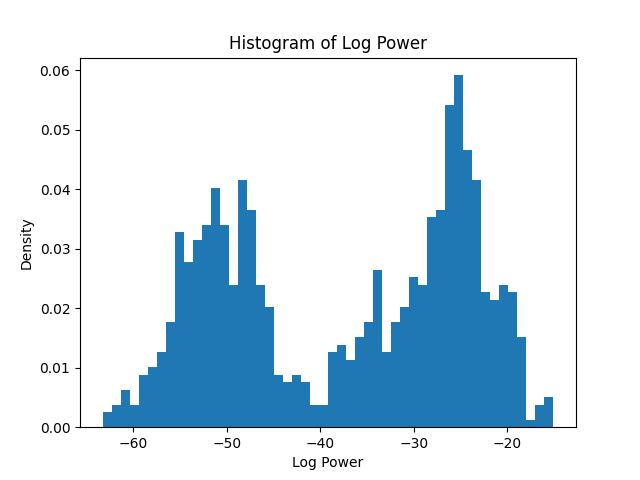

In [3]:
# YOUR CODE HERE
#frame the signal
frame_length = 320
hop_length = 160
frames = librosa.util.frame(clean_speech, frame_length=frame_length, hop_length=hop_length).T

#RMS energy for each frame
rms_power = librosa.feature.rms(y=clean_speech, frame_length=frame_length, hop_length=hop_length)[0]

#log power
log_power = 10 * np.log10(rms_power**2)

#power histogram
plt.hist(log_power, bins=50, density=True)
plt.xlabel('Log Power')
plt.ylabel('Density')
plt.title('Histogram of Log Power')
plt.show()

##### Fit GMM and Show Mean & Variances

In [8]:
# YOUR CODE HERE
from sklearn.mixture import GaussianMixture

#fit a GMM with two components to the speech power
gmm = GaussianMixture(n_components=2, random_state=0).fit(log_power.reshape(-1, 1))
print("means:\n",gmm.means_)
print("variances:\n",gmm.covariances_)

means:
 [[-27.00585477]
 [-50.74287888]]
variances:
 [[[28.47091134]]

 [[22.98497779]]]


##### Plot Gaussians in Histogram

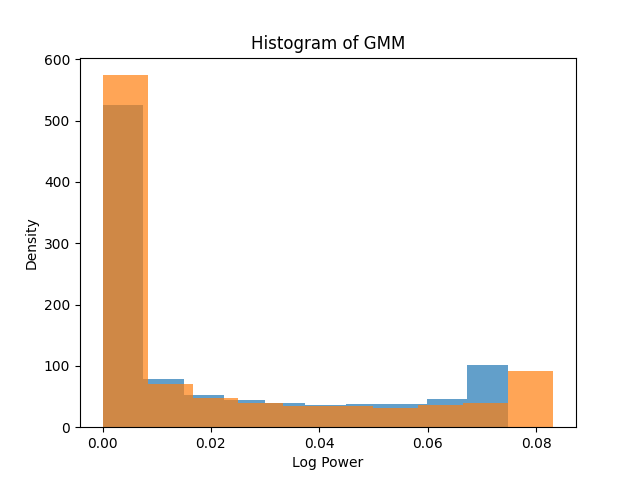

In [14]:
def gaussian(x, m, cov):
    """ Return probability for value(s) *x* of gaussian / normal distribution 
        with mean *m* and standard deviation *cov*
    """
    std = np.sqrt(cov)
    y = np.exp(-((x - m) / std)**2 / 2) / np.sqrt(2*np.pi) / std
    return y

# YOUR CODE HERE
x = np.linspace(log_power.min(), log_power.max(), 1000)
plt.figure()
plt.xlabel('Log Power')
plt.ylabel('Density')
plt.title('Histogram of GMM')
# Plot the GMM components
for i in range(2):
    mean = gmm.means_[i, 0]
    covariance = gmm.covariances_[i, 0, 0]
    plt.hist(gaussian(x, mean, covariance), label=f'Component {i+1}',alpha=0.7)
plt.show()
plt.legend()

In [16]:
# frames containing speech and posterior proba
# Identify which cluster corresponds to speech (typically the cluster with higher mean log power)
speech_cluster = np.argmax(gmm.means_)
print("Speech cluster:\n",speech_cluster)

# Compute the posterior probabilities for each frame
posterior_probs = gmm.predict_proba(log_power.reshape(-1, 1))[:, speech_cluster]
print("Posterior probabilities:\n",posterior_probs)

Speech cluster:
 0
Posterior probabilities:
 [1.09543455e-07 7.83979132e-07 3.11081933e-06 1.42431983e-06
 1.98518891e-08 1.15953015e-08 3.27160015e-09 9.57742273e-07
 1.46193735e-05 3.12725939e-06 6.03028996e-08 2.21629211e-06
 1.33140825e-06 9.34753424e-08 1.45773633e-07 5.78617736e-07
 3.14432739e-06 1.54592232e-06 2.11372447e-07 2.29312695e-07
 1.37559020e-06 1.38464619e-06 1.93543223e-06 2.76825102e-06
 1.79198508e-06 3.42002676e-06 3.57055609e-05 9.75225745e-05
 1.62097101e-05 7.58158970e-06 6.68572731e-04 3.40983963e-04
 8.53062892e-06 6.82113901e-04 2.53412727e-04 8.94813171e-06
 1.22577952e-05 1.50189652e-05 1.00848356e-05 3.89852732e-05
 1.05102469e-04 1.89550352e-06 3.68552260e-06 1.04038170e-04
 9.04233060e-05 1.00105633e-05 5.10747690e-04 5.71957795e-04
 1.22506237e-06 1.92076739e-07 4.20795607e-07 2.32985182e-07
 2.59273690e-07 1.02029687e-07 1.62554779e-08 1.81875268e-08
 1.24419526e-06 2.77782757e-06 1.63298367e-05 1.94345945e-05
 3.88523069e-07 3.18784231e-08 4.3068987

##### Test Function `vad_extraction`

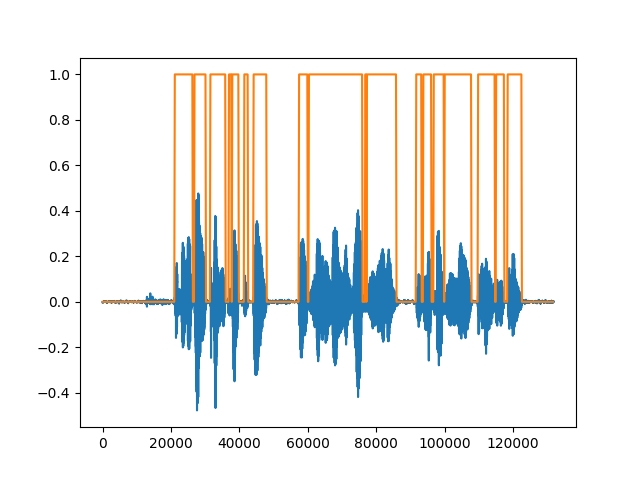

In [17]:
vad = vad_extraction(clean_speech)

_, axis= plt.subplots(1)

axis.plot(clean_speech)

xs = np.arange(len(vad)) * 160
axis.plot(xs, vad * np.max(np.abs(vad)))

## 6.2 Test 'Mix Noise and Speech'

In [ ]:
clean_speech_changed, noisy_speech = mix(clean_speech, noise, 5, [rir1, rir2])

_, axis = plt.subplots(1)
axis.plot(noisy_speech)
axis.plot(clean_speech_changed)

In [ ]:
sr = 16000
sd.play(np.concatenate((clean_speech, noisy_speech)), samplerate=sr)

## 6.3 Test 'Feature Extraction'

In [ ]:
features = feature_extraction(noisy_speech)
print(features.shape, '\n\n', features)

## 6.4 Test 'Generators'

In [ ]:
# test init, i.e. creating generator
gen_speech = GenSpeech(path_clean_speech)

# test __next__() two times
clean_speech_1 = next(gen_speech)
clean_speech_2 = next(gen_speech)

# plot retrieved example speech files
_, axes = plt.subplots(1,2)
axes[0].plot(clean_speech_1)
axes[1].plot(clean_speech_2)

# test __len__()
print(len(gen_speech))

# test if the generator runs until completion & stops
for speech in gen_speech:
    pass

In [ ]:
# test init, i.e. creating generator
gen_rirs = create_gen_rir(path_rirs)

# test __next__() two times
rir1 = next(gen_rirs)
rir2 = next(gen_rirs)

# plot retrieved example rirs
_, axes = plt.subplots(1,2)
axes[0].plot(rir1)
axes[1].plot(rir2)

## 6.5 Run Augmentation

In [ ]:
for split in ['train', 'val', 'test']:
    path = os.path.join(data_path, split)
    run_augmentation(path, debug=True)